In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC

In [2]:
df = pd.read_csv("cancer.csv")
#drop the unnamed gabage column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#strip all column names
df.columns = df.columns.str.strip()
df.shape

(4024, 15)

## Data Visualization

In [3]:
#convert all non-numerical features to string
numerical = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
df[df.columns.difference(numerical)] = df[df.columns.difference(numerical)].astype(str)

In [4]:
#Modify Grade and Race and Marital Status
df['Marital Status'] = df['Marital Status'].str.replace('Married (including common law)', 'Married', regex = False)
df['Marital Status'] = df['Marital Status'].str.replace('Single (never married)', 'Single', regex = False)
df['Race'] = df['Race'].str.replace('Other (American Indian/AK Native, Asian/Pacific Islander)','Other', regex = False)
df['Grade'] = df['Grade'].str.replace('Well differentiated; Grade I', 'I Well', regex = False)
df['Grade'] = df['Grade'].str.replace('Moderately differentiated; Grade II', 'II Moderately', regex = False)
df['Grade'] = df['Grade'].str.replace('Poorly differentiated; Grade III', 'III Poorly', regex = False)
df['Grade'] = df['Grade'].str.replace('Undifferentiated; anaplastic; Grade IV', 'IV Undifferentiated', regex = False)

In [5]:
df.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

#### The Distribution of Each Feature and their Relation to Status
The plot below shows 2 distributions of each feature. One of them is the distribtion of these features corresponding to the dead status and the other corresponds to alive status.

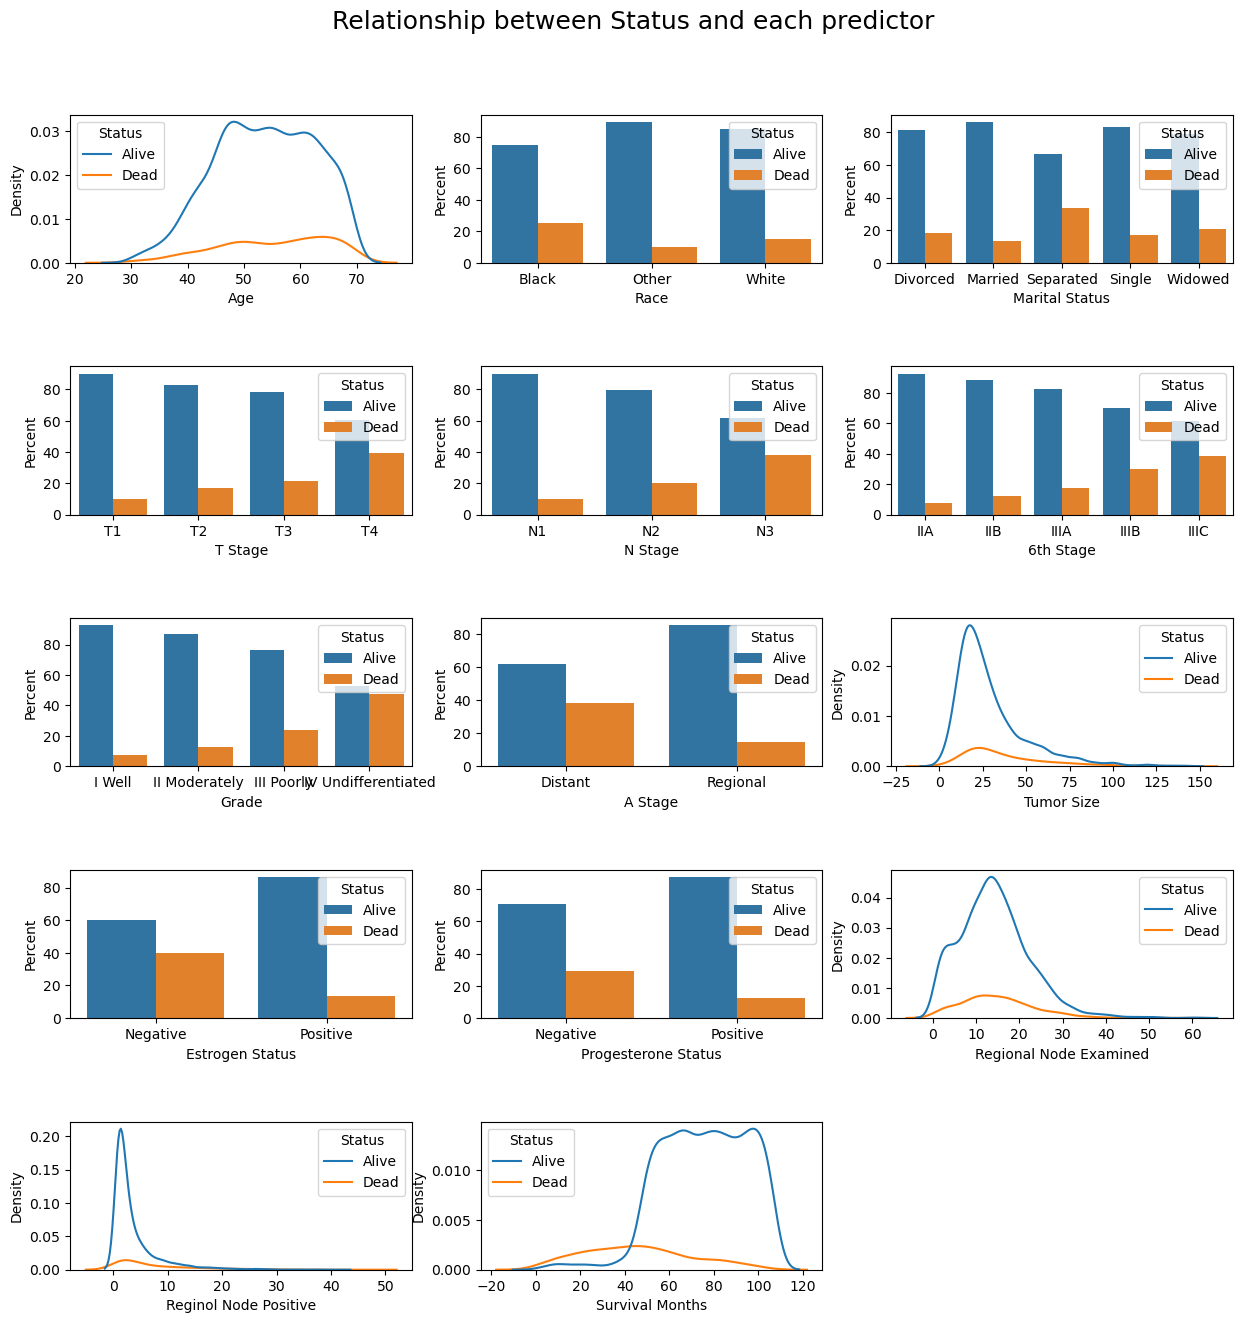

In [6]:
# define subplot grid
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
plt.subplots_adjust(hspace=0.7)
fig.suptitle("Relationship between Status and each predictor", fontsize=18, y=0.95)
# loop through tickers and axes
for i,p in enumerate(df.columns[:-1]):
    # filter df for ticker and plot on specified axes
    m, j = divmod(i, 3)
    if is_numeric_dtype(df[p]):
        sns.kdeplot(data=df,x=df[p],hue= 'Status',ax=axs[m,j])
    else:
        df1 = df.groupby(p)['Status'].value_counts(normalize=True)
        df1 = df1.mul(100)
        df1 = df1.rename('Percent').reset_index()
        sns.barplot(x=p,y='Percent',hue='Status',data=df1,ax=axs[m,j])
        #sns.countplot(data=df,x = df[p], hue = 'Status',ax=axs[m,j])
fig.delaxes(axs[4][2])
plt.show()

#plt.savefig('EDA1.png')
#fig.savefig('EDA1.png')   # save the figure to file
#plt.close(fig) 

<AxesSubplot: xlabel='Status', ylabel='count'>

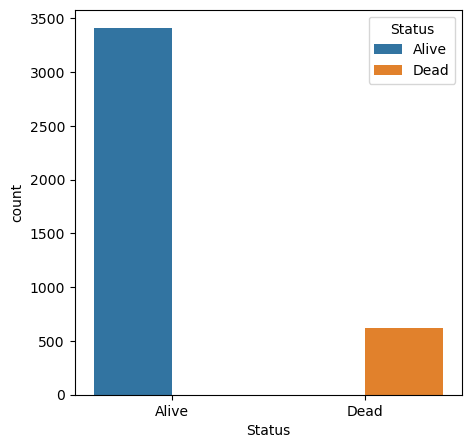

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df,x = df['Status'], hue = 'Status')

#plt.savefig('imbalance.png')   # save the figure to file
#plt.close(fig) 

<AxesSubplot: xlabel='Race', ylabel='count'>

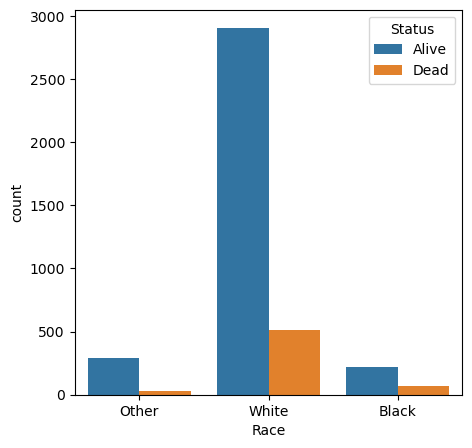

In [8]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df,x = df['Race'], hue = 'Status')
#plt.savefig('race.png')   # save the figure to file
#plt.close(fig) 

/var/folders/xq/kz9svrss4q94t4kr9f0zmm_w0000gn/T/ipykernel_26174/3899356113.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[:-1].corr(), annot=True)


<AxesSubplot: >

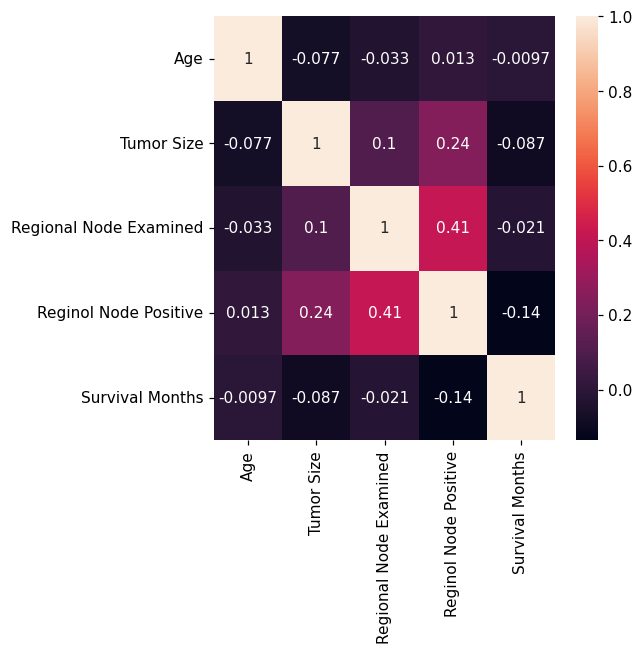

In [9]:
#df_cancer. = sns.load_dataset("cancer.csv")
plt.figure(figsize=(5, 5), dpi = 110)
#plotting the heatmap for correlation
sns.heatmap(df[:-1].corr(), annot=True)
#plt.savefig('heapmap.png')   # save the figure to file
#plt.close(fig) 

## Findings:
1. Survival Months appear to be the strongest predictor


## Issues that need to deal with:
1. Class imbalance, dead:alive = 0.18
2. In Race, way more data for white people than the black and others (American Indian, Asians). If use the 'Race' variable, could lead the model to be biased??

## Data Cleaning
#### Check if there is missing data
There is no missing data in this data set.

In [12]:
##check if there is missing data
df.isnull().values.any()

False

####  Simplify names and feature engineering

In [13]:
#replace alive with 1 and dead with 0
df['Status'].replace(['Alive', 'Dead'], [1, 0], inplace = True)

Create a new feature "Regional Ratio" that is the ratio of Regional Node Positive devided by Regional Node Examined.

The Ratio of positive Regional Node out of all examined regional node may be helpful.

In [14]:
df['Regional Ratio'] = df['Reginol Node Positive']/df['Regional Node Examined']

#### Convert Categorical variables to numerical ones
* Use one hot encoding for non-ordinal categorical data
* Use regular encoding for ordinal categorical data so that the order is preserved. 

#### Dropping and Replaceing some features
* We decide to drop the survival months feature

After careful review of the documents about the calculation of survival months, we found that the survival months in some records are calculated with the status information of that patient. The last contact, which is an important element in calculating the survival months, is calculated differently for patients with status information. Therefore, if we use this feature, there will be data leackage.

For detailed calculation method of the survival months, see this reference: https://seer.cancer.gov/survivaltime/SurvivalTimeCalculation.pdf

* We also replace "Regional Node Examined","Reginol Node Positive" by "Regional Ratio" as we think ratio of these two variables are more informative.

In [15]:
##first do the train test split
y = df['Status']
X = df.drop('Status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0, stratify = y, shuffle=True)

In [16]:
cat_nominal_cols = ['Race', 'Marital Status', 'A Stage', 'Estrogen Status', 'Progesterone Status']
cat_ordinal_cols = ['T Stage', 'N Stage', '6th Stage', 'Grade']
numerical_cols = ['Age', 'Tumor Size', 'Regional Ratio']

Use OneHotEncoder() to convert nominal variables

In [17]:
ohe = OneHotEncoder(drop = 'first',  sparse = False, handle_unknown = 'ignore') 
ohe_train = ohe.fit_transform(X_train[cat_nominal_cols])

In [18]:
ohe_train_df = pd.DataFrame(ohe_train, columns = ohe.get_feature_names_out())

In [19]:
ohe_test = ohe.transform(X_test[cat_nominal_cols])
ohe_test_df = pd.DataFrame(ohe_test, columns = ohe.get_feature_names_out())

Use Ordinal Encoder to encode ordinal categorical features.

In [20]:
ore = OrdinalEncoder()
ore_train = ore.fit_transform(X_train[cat_ordinal_cols])

In [21]:
ore_train_df = pd.DataFrame(ore_train, columns = cat_ordinal_cols)

In [22]:
ore_test = ore.transform(X_test[cat_ordinal_cols])
ore_test_df = pd.DataFrame(ore_test, columns = cat_ordinal_cols)

Concatenate transformed categorical data with numerical data

In [23]:
X_train = pd.concat([X_train[numerical_cols].reset_index(drop=True), ohe_train_df, ore_train_df], axis = 1)

In [24]:
X_test = pd.concat([X_test[numerical_cols].reset_index(drop=True), ohe_test_df, ore_test_df], axis=1)

#### Standardize the numerical features

In [25]:
age_mean = X_train['Age'].mean()
age_std = X_train['Age'].std()
tumor_mean = X_train['Tumor Size'].mean()
tumor_std = X_train['Tumor Size'].std()
regional_mean = X_train['Regional Ratio'].mean()
regional_std = X_train['Regional Ratio'].std()
X_train['Age'] = (X_train['Age']-age_mean)/age_std
X_test['Age'] = (X_test['Age']-age_mean)/age_std
X_train['Tumor Size'] = (X_train['Tumor Size'] - tumor_mean)/tumor_std
X_test['Tumor Size'] = (X_test['Tumor Size']-tumor_mean)/tumor_std
X_train['Regional Ratio'] = (X_train['Regional Ratio'] - regional_mean)/regional_std
X_test['Regional Ratio'] = (X_test['Regional Ratio'] - regional_mean)/regional_std

#### Oversampling with SMOTENC
Class inbalance between dead and alive status exists. So, need oversampling.

__Note that we only apply oversampling technique on train set but not on test set; otherwise, the same records could show up in both train and test set.__

In [26]:
#class imbalance, need to oversample/undersample
ratio = len(df[df['Status'] == 0])/len(df[df['Status'] == 1])
ratio

0.1807511737089202

In [27]:
print('Class count before oversample: ')
for class_type, value in Counter(y_train).items():
    print(' -', class_type, value)

Class count before oversample: 
 - 1 2726
 - 0 493


In [28]:
cat = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
smotenc = SMOTENC(categorical_features=cat, random_state=5)
X_train, y_train = smotenc.fit_resample(X_train, y_train)

In [29]:
print('Class count after oversample: ')
for class_type, value in Counter(y_train).items():
    print(' -', class_type, value)

Class count after oversample: 
 - 1 2726
 - 0 2726


## Project Question
1. We want to build a classifier that will classify a patient's status using all 16 features. 
    * Independent variables are: 'Age', 'Tumor Size', 'Regional Ratio', 'Race_Other', 'Race_White',
       'Marital Status_Married', 'Marital Status_Separated',
       'Marital Status_Single', 'Marital Status_Widowed', 'A Stage_Regional',
       'Estrogen Status_Positive', 'Progesterone Status_Positive', 'T Stage',
       'N Stage', '6th Stage', 'Grade'
    * response variable is: status
    
2. We also want to build a blending/stacking classifier and see if it outperforms the baseline model. If no, why a single model is better then the blending/stacking one.

3. We want to measure the feature importance. Which feature is most important in classifying a patient's status.

## Baseline Model
We decide to use a Decision Tree as our baseline model. We choose the best hyperparameter using Cross Validation

In [31]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve

In [32]:
tree_depth = np.arange(1, 21)
train_roc = []
cv_roc = []
cv_roc_std = []
train_acc = []
cv_acc = []
cv_acc_std = []
train_f1 = []
cv_f1 = []
cv_f1_std = []

for depth in tree_depth:
    dt = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(dt, X_train, y_train, cv=5, scoring=("roc_auc",'accuracy','f1'), return_train_score=True)
    train_roc.append(np.mean(scores['train_roc_auc']))
    cv_roc.append(np.mean(scores['test_roc_auc']))
    cv_roc_std.append(np.std(scores['test_roc_auc']))

    train_acc.append(np.mean(scores['train_accuracy']))
    cv_acc.append(np.mean(scores['test_accuracy']))
    cv_acc_std.append(np.std(scores['test_accuracy']))


    train_f1.append(np.mean(scores['train_f1']))
    cv_f1.append(np.mean(scores['test_f1']))
    cv_f1_std.append(np.std(scores['test_f1']))

In [33]:
best_depth = np.argmax(cv_roc)+1
base_line_tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)
base_line_pred = base_line_tree.predict_proba(X_test)[:,1]
pct_fpr, pct_tpr ,threshold = roc_curve(y_test, base_line_pred)
base_line_auc = auc(pct_fpr, pct_tpr)
print('AUC of Base line Model(test)', base_line_auc)

base_line_pred_train = base_line_tree.predict_proba(X_train)[:,1]
pct_fpr_train, pct_tpr_train ,threshold_train = roc_curve(y_train, base_line_pred_train)
base_line_auc_train = auc(pct_fpr_train, pct_tpr_train)
print('AUC of Base line Model(train)', base_line_auc_train)

AUC of Base line Model(test) 0.5975192523186229
AUC of Base line Model(train) 0.9298528234672878


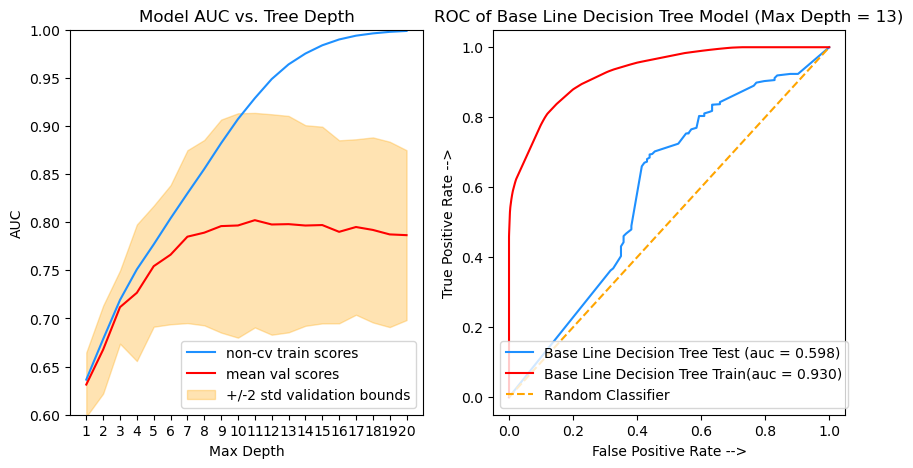

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
ax1.plot(
    tree_depth,
    train_roc,
    color = 'dodgerblue',
    label = 'non-cv train scores'
)
ax1.plot(
    tree_depth,
    cv_roc,
    color = 'red',
    label = 'mean val scores'
)
ax1.fill_between(tree_depth,
                np.array(cv_roc) - 2 * np.array(cv_roc_std), 
                np.array(cv_roc) + 2 * np.array(cv_roc_std), 
                color='orange',
                label = '+/-2 std validation bounds',
                alpha=.3)
ax1.legend()
ax1.set_xlabel('Max Depth')
ax1.set_ylabel("AUC")
ax1.set_title('Model AUC vs. Tree Depth')
ax1.set_xticks(tree_depth)
ax1.set_ylim((0.6,1))

ax2.plot(pct_fpr, pct_tpr, linestyle='-', color = 'dodgerblue',label='Base Line Decision Tree Test (auc = %0.3f)' % base_line_auc)
ax2.plot(pct_fpr_train, pct_tpr_train, linestyle='-', color = 'red',label='Base Line Decision Tree Train(auc = %0.3f)' % base_line_auc_train)
ax2.plot(pct_fpr,pct_fpr,linestyle='--', label='Random Classifier', color = 'orange')
ax2.set_xlabel('False Positive Rate -->')
ax2.set_ylabel('True Positive Rate -->')
ax2.set_title('ROC of Base Line Decision Tree Model (Max Depth = 13)')

ax2.legend()

## Further Model Exploration
We decide to use KNN, Random Forest and Adaboost in our stacking classifier.

In [37]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import roc_auc_score

First, we do not tune our models but rather start from arbitrary initial parameter settings and do CV on these four classifiers (KNN, Random Forest, Adaboost, Stacking classifier of the before three models) to get a feeling of their performance.

__Observation:__ in StackingClassifier(), if we set use_probas = True, average_probas = False (i.e. the class-probabilities, instead of classes, of the first-level classifiers is used to train the meta-classifier), the accuracy will be lower in both train and test set.

In [196]:
clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = RandomForestClassifier(random_state = 1, n_estimators = 200, max_features = 'sqrt', max_depth=3)
clf3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100, learning_rate=.1)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers = [clf1, clf2, clf3], 
                          meta_classifier = lr,
                          use_probas = True,
                          average_probas = False
                         )

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'AdaBoostClassifier',
                       'StackingClassifier']):
    
    train_scores = cross_val_score(clf, X_train, y_train, cv = 3, scoring = 'accuracy')
    test_score = clf.fit(X_train, y_train).score(X_test, y_test)
    
    print('Train: %0.2f (+/- %0.2f) | Test: %0.2f [%s]' 
          % (train_scores.mean(), train_scores.std(), test_score, label))

Train: 0.80 (+/- 0.02) | Test: 0.68 [KNN]
Train: 0.67 (+/- 0.02) | Test: 0.75 [Random Forest]
Train: 0.85 (+/- 0.08) | Test: 0.84 [AdaBoostClassifier]
Train: 0.83 (+/- 0.03) | Test: 0.77 [StackingClassifier]


In [219]:
sclf_test_AUC = roc_auc_score(y_test, sclf.predict_proba(X_test)[:,1])
print("Stacking classifer auc: {}".format(sclf_test_AUC))

Stacking classifer auc: 0.6734496817108933


Then, we do a GridSearchCV on the stacking model to find the best parameters in terms of:

* number of neighbors in KNN
* number of estimators in Random Forest
* Max depth in Random Forest
* number of estimators in Adaboost
* base estimator of Adaboost
* Learning Rate in Adaboost

In [ ]:
clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier() #random_state = 1,criterion = 'gini'
clf3 = AdaBoostClassifier() # DecisionTreeClassifier(max_depth = 1)
lr = LogisticRegression()


estimators = [('knn', clf1),
              ('rf', clf2),
             ('ada',clf3)]
sclf = StackingClassifier(estimators = estimators, final_estimator=lr)
params = {'knn__n_neighbors': list(range(1,20)),
          'rf__n_estimators': list(range(50,250,50)),
          'rf__max_depth': [3,5,7],
          'ada__n_estimators': list(range(50,250,50)),
          'ada__base_estimator': [DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)],
          'ada__learning_rate': [0.001,0.01,0.05,0.1] }
grid = GridSearchCV(estimator=sclf, param_grid=params,verbose=2, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)

We ran the above code in another noterbook and here is the results:
* number of neighbors in KNN: 3
* number of estimators in Random Forest: 200
* Max depth in Random Forest: 3
* number of estimators in Adaboost: 100
* base estimator of Adaboost: DecisionTreeClassifier(max_depth=3)
* Learning Rate in Adaboost; 0.1

Refit the 4 models using the optimal parameters obtained above:

In [201]:
clf1 = KNeighborsClassifier(n_neighbors = 3)
clf2 = RandomForestClassifier(n_estimators = 200, max_depth = 3)
clf3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 100, learning_rate = .1)
lr = LogisticRegression()

sclf = StackingClassifier(classifiers = [clf1, clf2, clf3], meta_classifier = lr, use_probas = True,
                          average_probas = False)

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'AdaBoostClassifier',
                       'StackingClassifier']):
    
    train_scores = cross_val_score(clf, X_train, y_train, cv = 3, scoring = 'accuracy')
    test_score = clf.fit(X_train, y_train).score(X_test, y_test)
    
    print('Train: %0.2f (+/- %0.2f) | Test: %0.2f [%s]' 
          % (train_scores.mean(), train_scores.std(), test_score, label))

Train: 0.78 (+/- 0.02) | Test: 0.66 [KNN]
Train: 0.72 (+/- 0.02) | Test: 0.72 [Random Forest]
Train: 0.84 (+/- 0.08) | Test: 0.85 [AdaBoostClassifier]
Train: 0.85 (+/- 0.05) | Test: 0.77 [StackingClassifier]


__Observation:__ GridSearchCV on stacking classifier selects hyperparameters that are best for the stacking classifier, but not necessarily for the single estimator in the stacking classifier. 

__Observation:__ StackingClassifier does not outperform a single adaboost model and is harder to interpret.

## Do grid search cv on adaboost

In [28]:
ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 150)
params = {'base_estimator__max_depth': [1, 2, 4, 6, 8],
        'learning_rate':[0.05, 0.1, 0.2, 0.4, 1],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}
grid1 = GridSearchCV(estimator = ada1, param_grid = params, cv = 5,refit = True)
grid1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                          n_estimators=150),
             param_grid={'base_estimator__max_depth': [1, 2, 4, 6, 8],
                         'learning_rate': [0.05, 0.1, 0.2, 0.4, 1],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350,
                                          400]})

In [29]:
print("Best parameters for Adaboost: {}".format(grid1.best_params_))
print("Accuracy of Adaboost: {}".format(grid1.best_score_))

Best parameters for Adaboost: {'base_estimator__max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 150}
Accuracy of Adaboost: 0.8813725308823652


In [387]:
##refit the adaboost on the entire data
ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4), n_estimators = 150, learning_rate = 0.1)
ada1.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.1, n_estimators=150)

In [389]:
train_accu = ada1.score(X_train, y_train)
val_accu = ada1.score(X_test, y_test)
print(train_accu, val_accu)

0.9468085106382979 0.8273291925465839


In [390]:
train_list = list(ada1.staged_score(X_train, y_train))
val_list = list(ada1.staged_score(X_test, y_test))

Best # trees: 134
Best validation accuracy: 0.8285714285714286


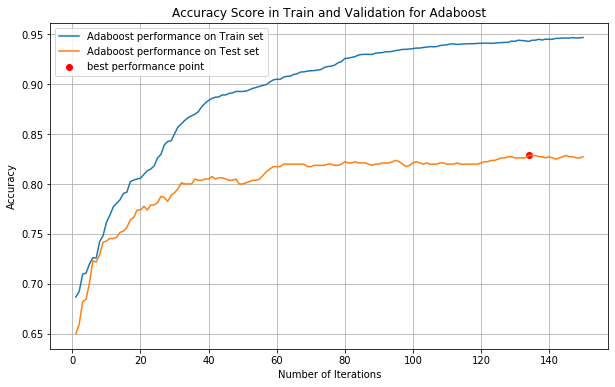

In [391]:
best_index = np.argmax(val_list)
print("Best # trees: {}".format(best_index+1))
print("Best validation accuracy: {}".format(val_list[best_index]))
plt.figure(figsize=(10, 6))
plt.plot(range(1, 151), train_list, label="Adaboost performance on Train set");
plt.plot(range(1, 151), val_list, label="Adaboost performance on Test set");
plt.scatter([best_index+1], [val_list[best_index]], c='red', label='best performance point');
plt.xlabel("Number of Iterations");
plt.ylabel("Accuracy");
plt.title("Accuracy Score in Train and Validation for Adaboost");
plt.legend();
plt.grid();

#### It seems that the refitted adaboost achieves the best test Accuracy at around 134
Let's take a look at the AUC score.

In [392]:
AUC_test = []
for pred in ada1.staged_predict_proba(X_test):
    pred_proba = pred[:,1]
    AUC_test.append(roc_auc_score(y_test, pred_proba))
AUC_train = []
for pred in ada1.staged_predict_proba(X_train):
    pred_proba = pred[:,1]
    AUC_train.append(roc_auc_score(y_train, pred_proba))

Best # trees: 11
Best test AUC: 0.718790978232363


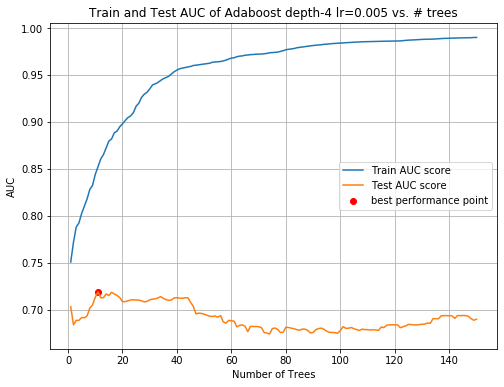

In [393]:
best_index = np.argmax(AUC_test)
print("Best # trees: {}".format(best_index+1))
print("Best test AUC: {}".format(AUC_test[best_index]))
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(AUC_train)+1), AUC_train, label="Train AUC score");
plt.plot(range(1, len(AUC_test)+1), AUC_test, label="Test AUC score");
plt.scatter([best_index+1], [AUC_test[best_index]], c='red', label="best performance point")
plt.grid();
plt.legend();
plt.xlabel("Number of Trees");
plt.ylabel("AUC");
plt.title("Train and Test AUC of Adaboost depth-4 lr=0.005 vs. # trees");

### Do another user-defined grid search


In [148]:
def CV10_adaboost(X_train, y_train, depth_list, lr_list, n_es=400, ada_random=1):
    import copy as cp
    ##10 fold validations
    Train = cp.copy(X_train)
    Train['status'] = y_train
    Train = Train.sample((Train.shape[0]//10)*10, random_state=1)
    Train_y = Train['status']
    Train_x = Train.drop(labels='status', axis=1)
    batch_size = int(Train_x.shape[0]/10)

    #filter all warnings
    import warnings
    warnings.filterwarnings("ignore")
    results = []
    params = {'base_estimator_max_depth': depth_list,
            'learning_rate':lr_list}
    n_estimator=n_es
    for depth in params['base_estimator_max_depth']:
        for lr in params['learning_rate']:
            print("depth: {}, lr={}".format(depth, lr))
            ##averaged validation AUC and accuracy 
            AUC = 0
            accuracy = 0
            ##for each batch
            for i in range(10):
                test = Train_x[batch_size*i:(batch_size*i+batch_size)]
                index = test.index
                train = Train_x[list(map(lambda i: i not in index, Train_x.index))]
                Y_test = Train_y[batch_size*i:(batch_size*i+batch_size)]
                Y_train = Train_y[list(map(lambda i: i not in index, Train_x.index))]
                ##fit on the train
                ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = depth), 
                                n_estimators = n_estimator, learning_rate=lr, random_state=ada_random)
                ada.fit(train, Y_train)
                proba_each_number = ada.staged_predict_proba(test)
                ##compute the AUC score on the validation data on each number of trees
                AUC_test = []
                for pred in proba_each_number:
                    pred = pred[:,1]
                    AUC_test.append(roc_auc_score(Y_test, pred))
                AUC_test = np.array(AUC_test)
                AUC += AUC_test
                ##compute the accuracy on the validation data on each number of trees
                accu = np.array(list(ada.staged_score(test, Y_test)))
                accuracy += accu
            ##average two lists
            AUC /= 10
            accuracy /= 10
            diction = {'depth':depth, 'lr':lr, 'AUC':AUC, 'accuracy':accuracy}
            results.append(diction) 
    return results
            
depth_list = [1, 2, 3, 4, 5, 6]
lr_list = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
n_estimator = 300
results = CV10_adaboost(X_train, y_train, depth_list, lr_list, n_es=n_estimator, ada_random=30)

depth: 1, lr=0.02
depth: 1, lr=0.04
depth: 1, lr=0.06
depth: 1, lr=0.08
depth: 1, lr=0.1
depth: 1, lr=0.12
depth: 1, lr=0.14
depth: 2, lr=0.02
depth: 2, lr=0.04
depth: 2, lr=0.06
depth: 2, lr=0.08
depth: 2, lr=0.1
depth: 2, lr=0.12
depth: 2, lr=0.14
depth: 3, lr=0.02
depth: 3, lr=0.04
depth: 3, lr=0.06
depth: 3, lr=0.08
depth: 3, lr=0.1
depth: 3, lr=0.12
depth: 3, lr=0.14
depth: 4, lr=0.02
depth: 4, lr=0.04
depth: 4, lr=0.06
depth: 4, lr=0.08
depth: 4, lr=0.1
depth: 4, lr=0.12
depth: 4, lr=0.14
depth: 5, lr=0.02
depth: 5, lr=0.04
depth: 5, lr=0.06
depth: 5, lr=0.08
depth: 5, lr=0.1
depth: 5, lr=0.12
depth: 5, lr=0.14
depth: 6, lr=0.02
depth: 6, lr=0.04
depth: 6, lr=0.06
depth: 6, lr=0.08
depth: 6, lr=0.1
depth: 6, lr=0.12
depth: 6, lr=0.14


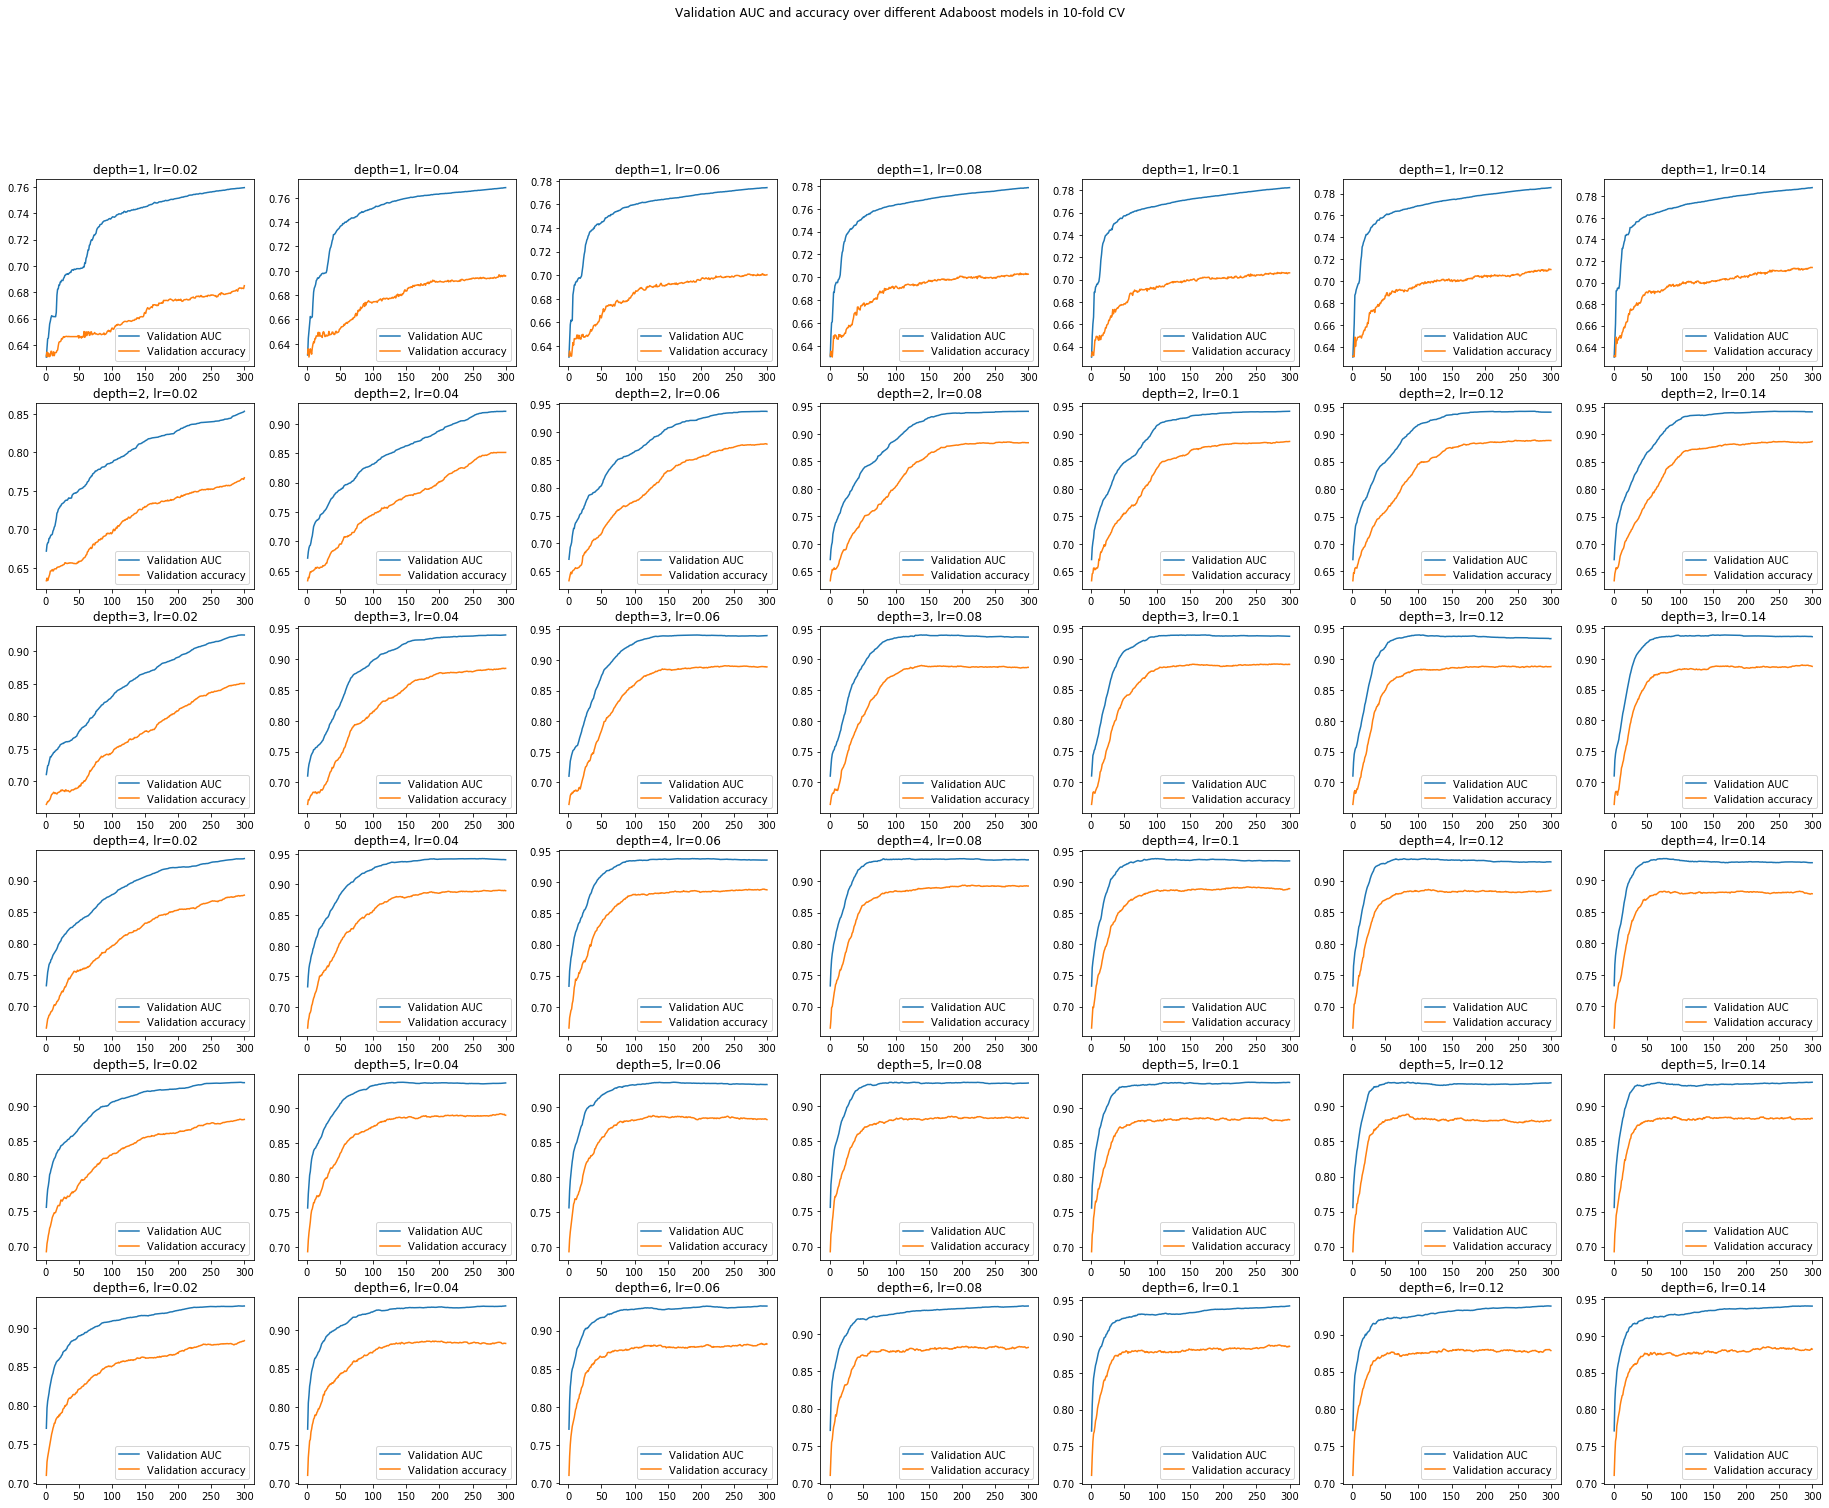

In [201]:
n_estimator=300
fig, ax = plt.subplots(6, 7, figsize=(32, 24));
for i, result in enumerate(results):
    j = i//7
    k = i%7
    ax[j, k].plot(range(1, n_estimator+1), result['AUC'], label="Validation AUC");
    ax[j, k].plot(range(1, n_estimator+1), result['accuracy'], label="Validation accuracy");
    ax[j, k].legend();
    ax[j, k].set_title("depth={}, lr={}".format(result['depth'], result['lr']));
fig.suptitle('Validation AUC and accuracy over different Adaboost models in 10-fold CV');
#fig.savefig("./10fold_CV_SMOTENC_nostd.png", dpi=500);

In [153]:
#search for the best combination
best_AUC_combi = (results[0], 0)
best_AUC = 0
best_accuracy_combi = (results[0], 0)
best_accuracy = 0
for result in results:
    best_auc_index = np.argmax(result['AUC'])
    best_accuracy_index = np.argmax(result['accuracy'])
    if result['AUC'][best_auc_index] > best_AUC:
        best_AUC = result['AUC'][best_auc_index]
        best_AUC_combi = (result, best_auc_index)
    if result['accuracy'][best_accuracy_index] > best_accuracy:
        best_accuracy = result['accuracy'][best_accuracy_index]
        best_accuracy_combi = (result, best_accuracy_index)

print("SMOTENC oversampling technique, ada randomseed: 30")
print('BEST According to AUC-------------------------------')
print("depth={}, lr={}, n_estimators={}".format(best_AUC_combi[0]['depth'], best_AUC_combi[0]['lr'], 
                                               best_AUC_combi[1]+1))
print("Best AUC: {}".format(best_AUC))
print('BEST According to accuracy-------------------------------')
print("depth={}, lr={}, n_estimators={}".format(best_accuracy_combi[0]['depth'], best_accuracy_combi[0]['lr'], 
                                               best_accuracy_combi[1]+1))
print("Best accuracy: {}".format(best_accuracy))

SMOTENC oversampling technique, ada randomseed: 30
BEST According to AUC-------------------------------
depth=2, lr=0.14, n_estimators=244
Best AUC: 0.9420966340813444
BEST According to accuracy-------------------------------
depth=4, lr=0.08, n_estimators=201
Best accuracy: 0.8935779816513761


### Refit the Adaboost with HP that maximizes Mean Validation AUC

Accuracy: 0.8496894409937888
AUC: 0.730539064921441


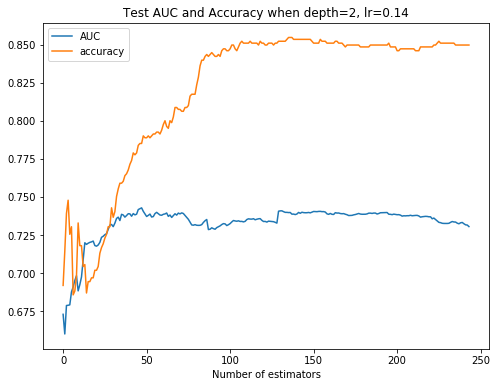

In [202]:
adabest = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators = 244, learning_rate=0.14)
adabest.fit(X_train, y_train)
proba_each_number = adabest.staged_predict_proba(X_test)
##compute the AUC score on the validation data on each number of trees
AUC_test = []
for pred in proba_each_number:
    pred = pred[:,1]
    AUC_test.append(roc_auc_score(y_test, pred))
plt.figure(figsize=(8, 6))
plt.plot(AUC_test, label="AUC");
plt.plot(list(adabest.staged_score(X_test, y_test)), label='accuracy')
plt.legend();
plt.xlabel("Number of estimators");
plt.title("Test AUC and Accuracy when depth=2, lr=0.14");
plt.savefig("./SMOTE-NC/test_AUC_accuracy_SMOTENC_d2_lrd14_adars30.png", dpi=200);
print("Accuracy: {}".format(adabest.score(X_test, y_test)))
print("AUC: {}".format(AUC_test[-1]))

### Oversample the Test set to See the Performance

We notice that there is a big gap between the mean validation AUC (0.94) and the test AUC (0.73). We think it is because the test set is inbalanced and therefore has a huge difference in terms of feature distribution compared with the over-sampled train set. So, we use SMOTE-NC to oversample the test set to see if the AUC improves. 

It turns out that after oversampling the test set the AUC becomes 0.9397, which is almost the same as mean validation AUC. So the hyperparameter we selected does not induce overfitting. This gap is caused by the class imbalance in the test set and there is no problem about it.

In [220]:
cat = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
smotenc = SMOTENC(categorical_features=cat, random_state=5)
X_testNC, y_testNC = smotenc.fit_resample(X_test, y_test)

Accuracy: 0.8995601173020528
AUC: 0.9396870511949502


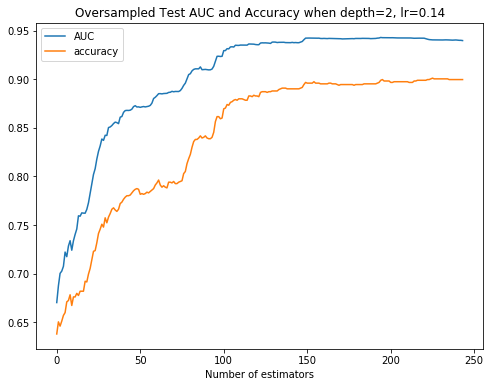

In [225]:
proba_each_number_NC = adabest.staged_predict_proba(X_testNC)
##compute the AUC score on the validation data on each number of trees
AUC_test_NC = []
for pred in proba_each_number_NC:
    pred = pred[:,1]
    AUC_test_NC.append(roc_auc_score(y_testNC, pred))
plt.figure(figsize=(8, 6))
plt.plot(AUC_test_NC, label="AUC");
plt.plot(list(adabest.staged_score(X_testNC, y_testNC)), label='accuracy')
plt.legend();
plt.xlabel("Number of estimators");
plt.title("Oversampled Test AUC and Accuracy when depth=2, lr=0.14");
plt.savefig("./SMOTE-NC/Oversampledtest_AUC_accuracy_SMOTENC_d2_lrd14_adars30.png", dpi=200);
print("Accuracy: {}".format(adabest.score(X_testNC, y_testNC)))
print("AUC: {}".format(AUC_test_NC[-1]))

### Repeat Above Process with Randomly Oversampled Train set

In [157]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0, stratify = y, shuffle=True)
ohe = OneHotEncoder(drop = 'first',  sparse = False, handle_unknown = 'ignore') 
ohe_train2 = ohe.fit_transform(X_train2[cat_nominal_cols])
ohe_train_df2 = pd.DataFrame(ohe_train2, columns = ohe.get_feature_names_out())
ohe_test2 = ohe.transform(X_test2[cat_nominal_cols])
ohe_test_df2 = pd.DataFrame(ohe_test2, columns = ohe.get_feature_names_out())
ore = OrdinalEncoder()
ore_train2 = ore.fit_transform(X_train2[cat_ordinal_cols])
ore_train_df2 = pd.DataFrame(ore_train2, columns = cat_ordinal_cols)
ore_test2 = ore.transform(X_test2[cat_ordinal_cols])
ore_test_df2 = pd.DataFrame(ore_test2, columns = cat_ordinal_cols)
X_train2 = pd.concat([X_train2[numerical_cols].reset_index(drop=True), ohe_train_df2, ore_train_df2], axis = 1)
X_test2 = pd.concat([X_test2[numerical_cols].reset_index(drop=True), ohe_test_df2, ore_test_df2], axis=1)
##standardize the numerical features
age_mean = X_train2['Age'].mean()
age_std = X_train2['Age'].std()
tumor_mean = X_train2['Tumor Size'].mean()
tumor_std = X_train2['Tumor Size'].std()
regional_mean = X_train2['Regional Ratio'].mean()
regional_std = X_train2['Regional Ratio'].std()
X_train2['Age'] = (X_train2['Age']-age_mean)/age_std
X_test2['Age'] = (X_test2['Age']-age_mean)/age_std
X_train2['Tumor Size'] = (X_train2['Tumor Size'] - tumor_mean)/tumor_std
X_test2['Tumor Size'] = (X_test2['Tumor Size']-tumor_mean)/tumor_std
X_train2['Regional Ratio'] = (X_train2['Regional Ratio'] - regional_mean)/regional_std
X_test2['Regional Ratio'] = (X_test2['Regional Ratio'] - regional_mean)/regional_std

### Randomly Oversample

In [158]:
print('Class count before oversample: ')
for class_type, value in Counter(y_train2).items():
    print(' -', class_type, value)
from imblearn.over_sampling import RandomOverSampler 
oversampler = RandomOverSampler(random_state=1)
X_train2, y_train2 = oversampler.fit_resample(X_train2, y_train2)
print('Class count after oversample: ')
for class_type, value in Counter(y_train2).items():
    print(' -', class_type, value)

Class count before oversample: 
 - 1 2726
 - 0 493
Class count after oversample: 
 - 1 2726
 - 0 2726


#### Grid search

In [185]:
depth_list = [1, 2, 3, 4, 5, 6]
lr_list = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
results2 = CV10_adaboost(X_train2, y_train2, depth_list, lr_list, n_es=300, ada_random=40)

depth: 1, lr=0.02
depth: 1, lr=0.04
depth: 1, lr=0.06
depth: 1, lr=0.08
depth: 1, lr=0.1
depth: 1, lr=0.12
depth: 1, lr=0.14
depth: 2, lr=0.02
depth: 2, lr=0.04
depth: 2, lr=0.06
depth: 2, lr=0.08
depth: 2, lr=0.1
depth: 2, lr=0.12
depth: 2, lr=0.14
depth: 3, lr=0.02
depth: 3, lr=0.04
depth: 3, lr=0.06
depth: 3, lr=0.08
depth: 3, lr=0.1
depth: 3, lr=0.12
depth: 3, lr=0.14
depth: 4, lr=0.02
depth: 4, lr=0.04
depth: 4, lr=0.06
depth: 4, lr=0.08
depth: 4, lr=0.1
depth: 4, lr=0.12
depth: 4, lr=0.14
depth: 5, lr=0.02
depth: 5, lr=0.04
depth: 5, lr=0.06
depth: 5, lr=0.08
depth: 5, lr=0.1
depth: 5, lr=0.12
depth: 5, lr=0.14
depth: 6, lr=0.02
depth: 6, lr=0.04
depth: 6, lr=0.06
depth: 6, lr=0.08
depth: 6, lr=0.1
depth: 6, lr=0.12
depth: 6, lr=0.14


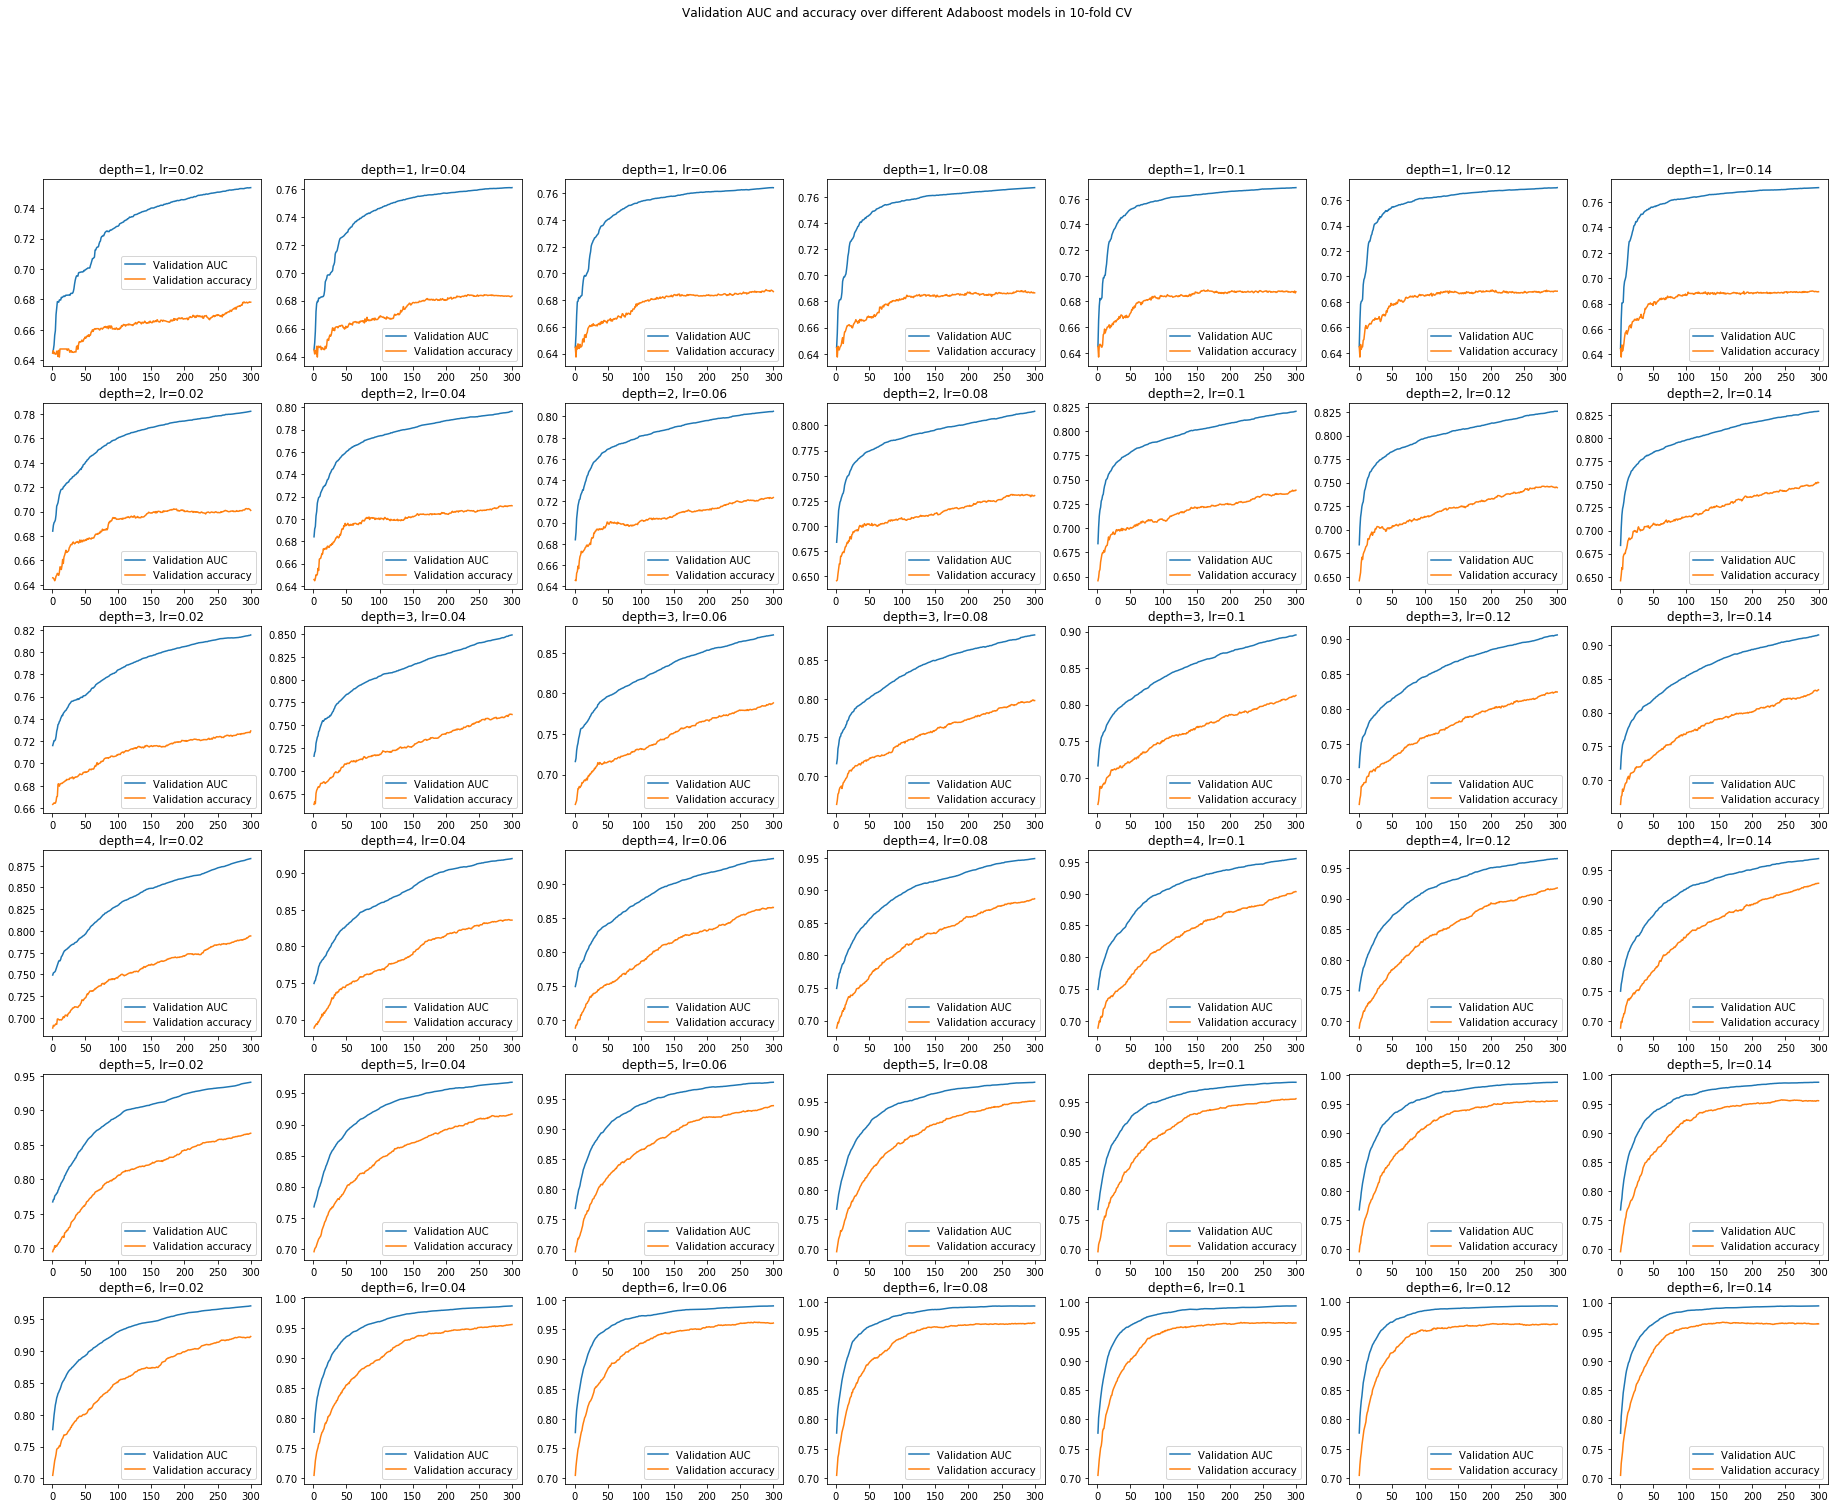

In [186]:
n_estimator=300
fig, ax = plt.subplots(6, 7, figsize=(32, 24));
for i, result in enumerate(results2):
    j = i//7
    k = i%7
    ax[j, k].plot(range(1, n_estimator+1), result['AUC'], label="Validation AUC");
    ax[j, k].plot(range(1, n_estimator+1), result['accuracy'], label="Validation accuracy");
    ax[j, k].legend();
    ax[j, k].set_title("depth={}, lr={}".format(result['depth'], result['lr']));
fig.suptitle('Validation AUC and accuracy over different Adaboost models in 10-fold CV');
#fig.savefig("./10fold_CV_SMOTENC_nostd.png", dpi=500);

In [188]:
#search for the best combination
best_AUC_combi = (results2[0], 0)
best_AUC = 0
best_accuracy_combi = (results2[0], 0)
best_accuracy = 0
for result in results2:
    best_auc_index = np.argmax(result['AUC'])
    best_accuracy_index = np.argmax(result['accuracy'])
    if result['AUC'][best_auc_index] > best_AUC:
        best_AUC = result['AUC'][best_auc_index]
        best_AUC_combi = (result, best_auc_index)
    if result['accuracy'][best_accuracy_index] > best_accuracy:
        best_accuracy = result['accuracy'][best_accuracy_index]
        best_accuracy_combi = (result, best_accuracy_index)

print("SMOTENC oversampling technique, ada randomseed: 30")
print('BEST According to AUC-------------------------------')
print("depth={}, lr={}, n_estimators={}".format(best_AUC_combi[0]['depth'], best_AUC_combi[0]['lr'], 
                                               best_AUC_combi[1]+1))
print("Best AUC: {}".format(best_AUC))
print('BEST According to accuracy-------------------------------')
print("depth={}, lr={}, n_estimators={}".format(best_accuracy_combi[0]['depth'], best_accuracy_combi[0]['lr'], 
                                               best_accuracy_combi[1]+1))
print("Best accuracy: {}".format(best_accuracy))

SMOTENC oversampling technique, ada randomseed: 30
BEST According to AUC-------------------------------
depth=6, lr=0.14, n_estimators=298
Best AUC: 0.9943492903723904
BEST According to accuracy-------------------------------
depth=6, lr=0.14, n_estimators=155
Best accuracy: 0.9664220183486238


Accuracy: 0.7937888198757764
AUC: 0.6156450420809194


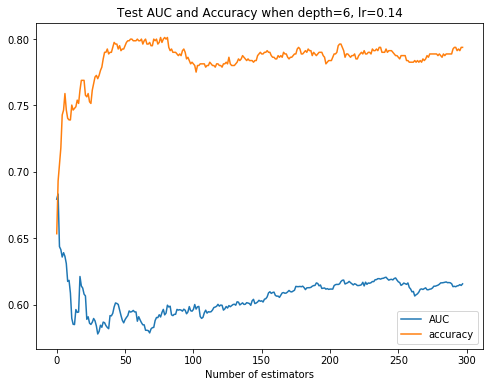

In [189]:
adabest2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 6), n_estimators = 298, learning_rate=0.14)
adabest2.fit(X_train, y_train)
proba_each_number = adabest2.staged_predict_proba(X_test)
##compute the AUC score on the validation data on each number of trees
AUC_test = []
for pred in proba_each_number:
    pred = pred[:,1]
    AUC_test.append(roc_auc_score(y_test, pred))
plt.figure(figsize=(8, 6))
plt.plot(AUC_test, label="AUC");
plt.plot(list(adabest2.staged_score(X_test, y_test)), label='accuracy')
plt.legend();
plt.xlabel("Number of estimators");
plt.title("Test AUC and Accuracy when depth=6, lr=0.14");
#plt.savefig("./SMOTE-NC/test_AUC_accuracy_SMOTENC_d2_lrd14_adars30.png", dpi=200);
print("Accuracy: {}".format(adabest2.score(X_test, y_test)))
print("AUC: {}".format(AUC_test[-1]))

### Plot the ROC of SMOTE-NC Adaboost and Random Oversample adaboost

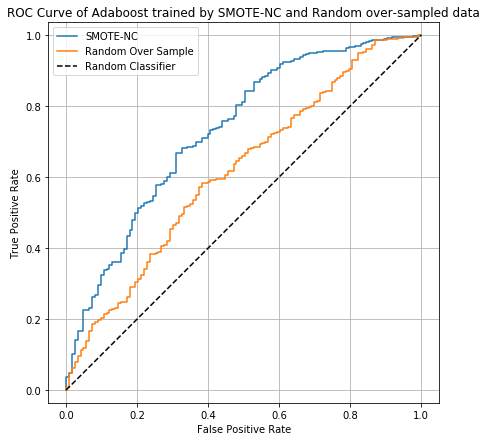

In [226]:
smote_result = adabest.predict_proba(X_test)[:,1]
reg_result = adabest2.predict_proba(X_test2)[:,1]

from sklearn import metrics
fpr_smote, tpr_smote, _ = metrics.roc_curve(y_test, smote_result)
fpr_reg, tpr_reg, _ = metrics.roc_curve(y_test, reg_result)

#create ROC curve
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.plot(fpr_smote,tpr_smote, label="SMOTE-NC")
plt.plot(fpr_reg,tpr_reg, label="Random Over Sample")
plt.plot([0, 1], [0, 1], '--', c='black', label='Random Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of Adaboost trained by SMOTE-NC and Random over-sampled data")
plt.grid();
plt.legend()
plt.savefig("./SMOTEvsRegOversample_ROC.png", dpi=200)

### Add the Stacking ROC

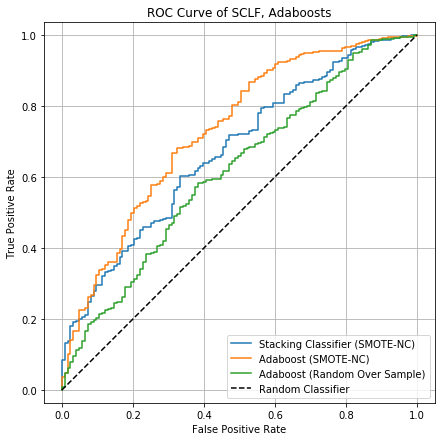

In [228]:
from sklearn import metrics
fpr_sclf, tpr_sclf, c = metrics.roc_curve(y_test, sclf.predict_proba(X_test)[:,1])

#create ROC curve
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.plot(fpr_sclf,tpr_sclf, label="Stacking Classifier (SMOTE-NC)")
plt.plot(fpr_smote,tpr_smote, label="Adaboost (SMOTE-NC)")
plt.plot(fpr_reg,tpr_reg, label="Adaboost (Random Over Sample)")
plt.plot([0, 1], [0, 1], '--', c='black', label='Random Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve of SCLF, Adaboosts")
plt.grid();
plt.legend()
plt.savefig("./sclfAdas_ROC.png", dpi=200)

## Feature Importance

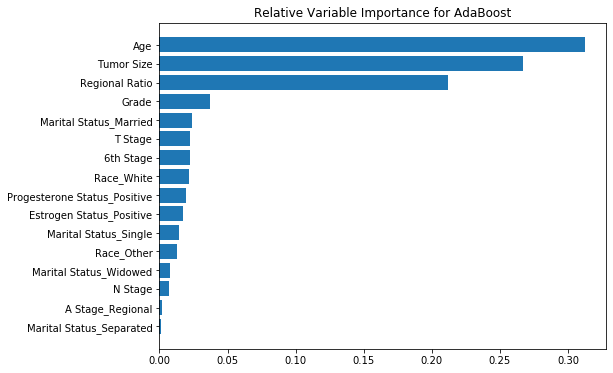

In [178]:
num_features = len(X_train.columns)
importances = adabest.feature_importances_
order = np.argsort(importances)[-num_features:]
plt.figure(figsize=(8, 6))
plt.barh(range(num_features), importances[order], tick_label = X_train.columns[order]);
plt.title(f"Relative Variable Importance for AdaBoost")    
plt.savefig("featureImportance_byBestAda.png", dpi=300, bbox_inches='tight')

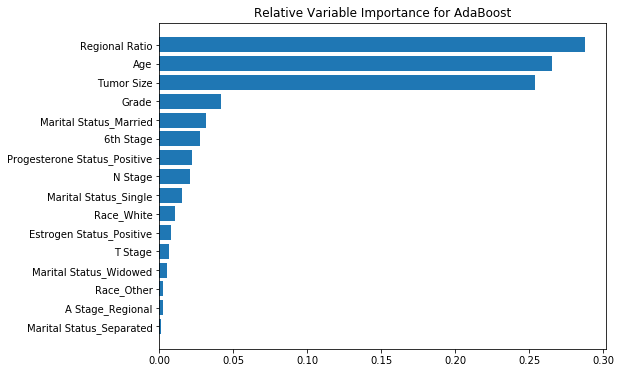

In [179]:
num_features = len(X_train2.columns)
importances = adabest2.feature_importances_
order = np.argsort(importances)[-num_features:]
plt.figure(figsize=(8, 6))
plt.barh(range(num_features), importances[order], tick_label = X_train2.columns[order]);
plt.title(f"Relative Variable Importance for AdaBoost")    
plt.savefig("featureImportance_byBestAda_byRandom.png", dpi=300, bbox_inches='tight')

In [ ]:
#Permutation feature importance 
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(adabest, random_state, n_iter = 10).fit(X_train, y_train)
feature_matrix = eli5.show_weights(perm, feature_names = X_train.columns.tolist())